# Dealing with Photometric Selection Effects

Part 3.3 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to modify the photometric likelihoods derived in Part 3.2 to deal with **selection effects**.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

As before, we will use our mock SDSS data to benchmark our tests here.

In [2]:
sdss = pickle.load(open( "data/mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples, sdss.samples_t # import truth labels

We'll again subdivide our data into two samples with different selection cuts applied.

In [3]:
# dividing into training/testing samples
Nobs = sdss.NSAMPLES
Ntrain, Ntest = 100000, 50000

sel_train = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 2.] # r-band S/N>2 cut
train_sel = sel_train[:Ntrain] # training set

sel_test = arange(Nobs)[sdss.phot_obs[:,2] / sdss.noise[:,2] > 10.] # r-band S/N>10 cut
test_sel = sel_test[sel_test>train_sel[-1]][:Ntest] # testing set

print 'Number of observed galaxies (all):', Nobs
print 'Number of training galaxies:', Ntrain
print 'Number of testing galaxies:', Ntest

Number of observed galaxies (all): 500000
Number of training galaxies: 100000
Number of testing galaxies: 50000


Let's now initialize our photometry.

In [4]:
# initializing photometry
phot_train, phot_test = sdss.phot_obs[train_sel], sdss.phot_obs[test_sel]
err_train, err_test = sdss.noise[train_sel], sdss.noise[test_sel]

# initializing masks
mask = ones((Ntrain+Ntest, sdss.NFILTER), dtype='bool')
mask_train, mask_test = mask[:Ntrain], mask[Ntrain:Ntrain+Ntest]

Our standard likelihood is 

\begin{equation}
\boxed{
-2\ln P(g|h) = ||\Delta\mathbf{\hat{F}}_{gh}||_{\mathbf{\hat{C}}_{g+h}^{-1}} - p \quad , \quad \mathbf{\hat{C}}_{g+h} = \mathbf{\hat{C}}_g + \mathbf{\hat{C}}_h
}
\end{equation}

As with our use KDE and an associated smoothing scale to estimate our $P(z|g)$ and $N(z|\mathbf{g})$ distributions, we can easily add in an additional **smoothing covariance kernel** $\mathbf{C}_h$ over our training set $\mathbf{h}$ to improve our photometric inference. As with binning, this simply sets a fundamental photometric scale over $\mathbf{F}$ over which we can conduct meaningful inference.

We choose to implement our smoothing kernel in magnitude rather than flux space (i.e. logarithmic rather than linear) by smoothing all training galaxy photometry by some percent in all bands.

In [5]:
pkern = ones(sdss.NFILTER)*0.05 # photometric Gaussian kernel standard deviation (smoothing)
err_train_smooth = sqrt(err_train**2 + (pkern*phot_train)**2) # add kernel to training objects

Now let's plot up our sample.

In [6]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
mag, magerr = fz.asinh_mag_map(sdss.phot_obs, sdss.noise, # map f_nu to asinh mag
                               skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # softening parameter and zero-point

# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr) # discretized magnitudes

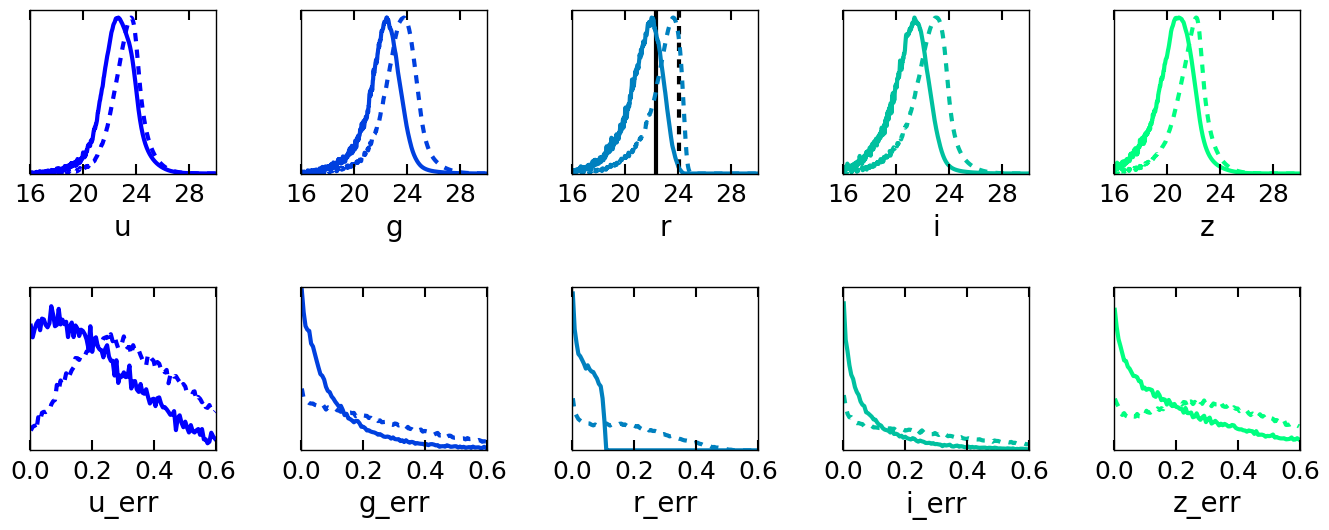

In [7]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,sdss.NFILTER)) # filter colors
figure(figsize=(14,6))
for i in xrange(sdss.NFILTER):
    subplot(2,sdss.NFILTER,i+1)
    mag_pdf = fz.pdf_kde_dict(mdict.sig_dict, mdict.sig_width, magidx[train_sel,i], mageidx[train_sel,i], ones(Ntrain),
                              mdict.grid, mdict.delta, Ntrain, mdict.Ngrid)
    plot(mdict.grid, mag_pdf/mag_pdf.max(), lw=3, linestyle='--', color=fcolors[i]) # training data
    mag_pdf = fz.pdf_kde_dict(mdict.sig_dict, mdict.sig_width, magidx[test_sel,i], mageidx[test_sel,i], ones(Ntest),
                              mdict.grid, mdict.delta, Ntest, mdict.Ngrid)
    plot(mdict.grid, mag_pdf/mag_pdf.max(), lw=3, color=fcolors[i]) # testing data
    if i==2: 
        vlines(sdss.MDEPTHS[i]-2.5*log10(2./5.), mag_pdf.max()*1.05, mag_pdf.min(), color='black', lw=3, linestyles='--')
        vlines(sdss.MDEPTHS[i]-2.5*log10(10./5.), mag_pdf.max()*1.05, mag_pdf.min(), color='black', lw=3)
    xlim([16, 30])
    yticks([])
    ylim([None,1.05])
    xticks(arange(16,30,4), fontsize=18)
    xlabel(sdss.filters[i], fontsize=20)
    tight_layout()
    subplot(2,sdss.NFILTER,i+1+sdss.NFILTER)
    h, bins = histogram(magerr[train_sel,i], normed=True, range=[0,0.6], bins=100)
    plot((bins[:-1]+bins[1:])/2., h, lw=3, color=fcolors[i], linestyle='--') # training data
    h, bins = histogram(magerr[test_sel,i], normed=True, range=[0,0.6], bins=100)
    plot((bins[:-1]+bins[1:])/2., h, lw=3, color=fcolors[i]) # testing data
    xticks(linspace(0,0.6,4), fontsize=18)
    xlabel(sdss.filters[i]+'_err', fontsize=20)
    yticks([])
    tight_layout()

In [8]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lzidx, lzeidx = rdict.fit(log(1+redshifts), ones(Nobs)*rdict.dlz) # discretized ln(1+z)

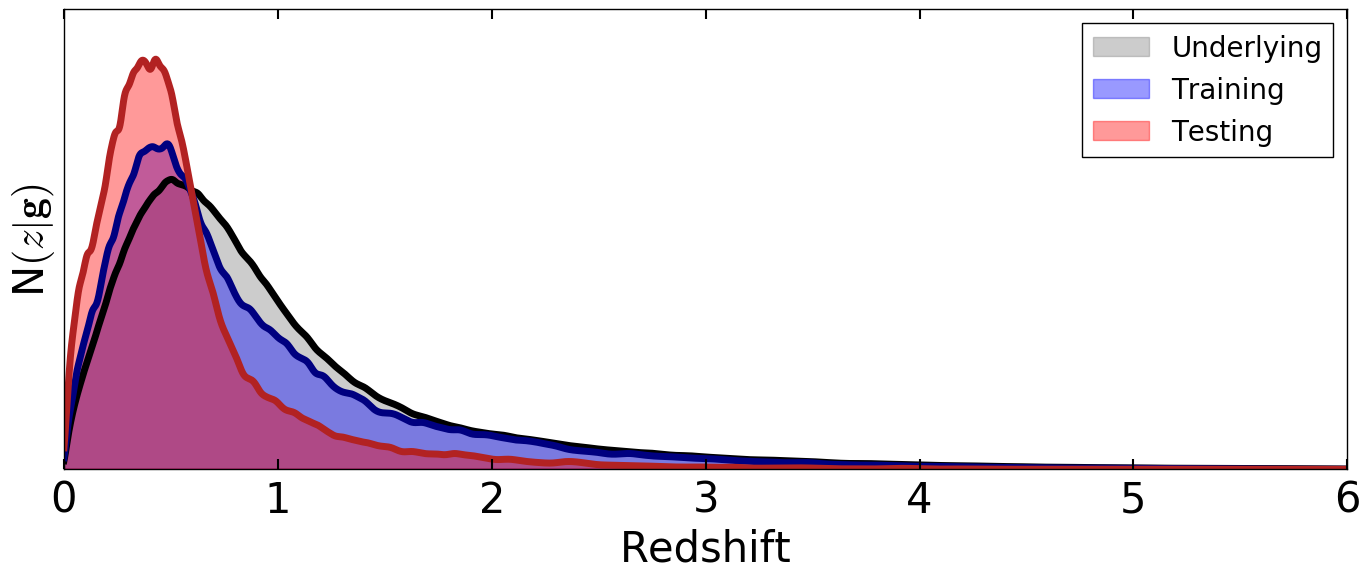

In [9]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                       rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black')
fill_between(rdict.zgrid_highres, z_pdf, color='gray', alpha=0.4, label='Underlying')

# training
z_pdf_train = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], ones(Ntrain),
                              rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf_train = z_pdf_train[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf_train /= z_pdf_train.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf_train, lw=5, color='navy')
fill_between(rdict.zgrid_highres, z_pdf_train, color='blue', alpha=0.4, label='Training')

# testing
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing
plot(rdict.zgrid_highres, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_highres, z_pdf, color='red', alpha=0.4, label='Testing')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('N$(z|\mathbf{g})$')

## Selection Effects: Theory

In Part 3.1, we outlined our basic likelihood as
$$ 
P(g|h) = \int P(\mathbf{F}) P(g|h,\mathbf{F}) \, d\mathbf{F} 
= \int P(\mathbf{F}) \, P(\mathbf{F}|g) \,  P(\mathbf{F}|h) \, d\mathbf{F} 
= \int P(\mathbf{F}) \, K_g(\mathbf{F}|\mathbf{\hat{F}}_g) \,  K_h(\mathbf{F}|\mathbf{\hat{F}}_h) \, d\mathbf{F} 
$$ 

where $P(\mathbf{F})$ is a prior over the flux densities across $\mathbf{b}$. Taking $K_g(\mathbf{F}|\mathbf{\hat{F}}_g) = \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)$ and $K_h(\mathbf{F}|\mathbf{\hat{F}}_h) = \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_h,\mathbf{\hat{C}}_h)$ to be a **multivariate Normal** (i.e. Gaussian) distribution and $P(\mathbf{F})$ to be uniform, we find

$$ 
P(g|h) = \int \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)  \,  \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_h,\mathbf{\hat{C}}_h)  \, d\mathbf{F} 
= \mathcal{N}(\Delta\mathbf{\hat{F}}_{gh}|\mathbf{0},\mathbf{\hat{C}}_{g+h}) 
= \frac{\exp\left[-\frac{1}{2}||\Delta\mathbf{\hat{F}}_{gh}||_{\mathbf{\hat{C}}_{g+h}^{-1}}\right]}{(2\pi)^{N_b/2}|\mathbf{\hat{C}}_{g+h}|^{1/2}} \quad .
$$ 

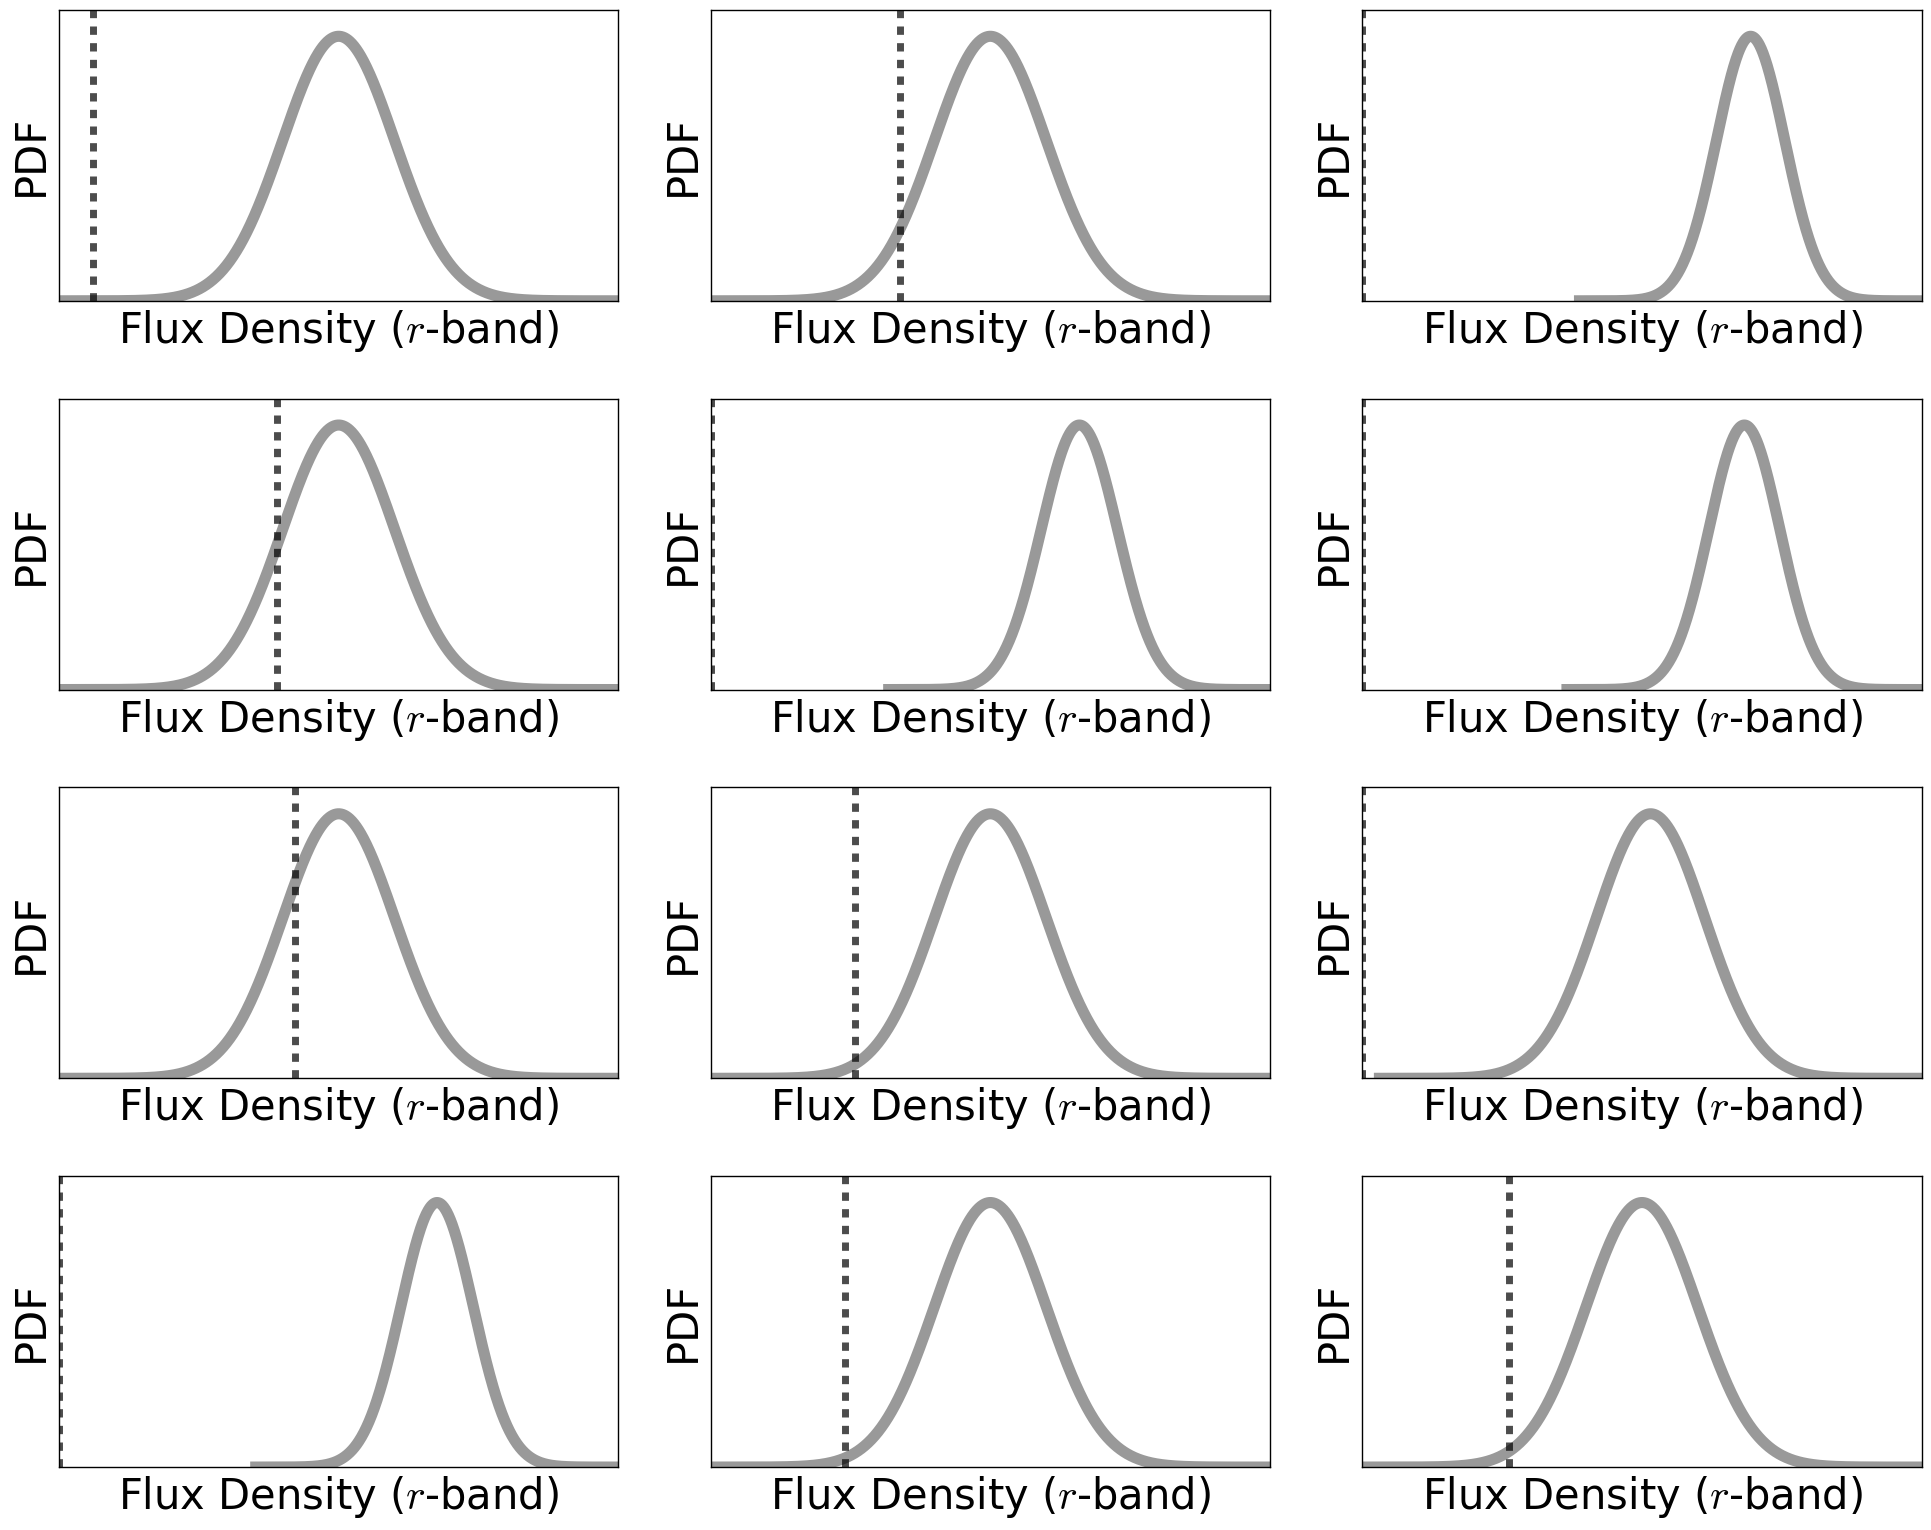

In [10]:
# select a few sample objects
idx = choice(Ntest, size=12, replace=None)
ftrain, etrain, etrain_smooth = phot_train[idx,2], err_train[idx,2], err_train_smooth[idx,2]

# plotting results
figure(figsize=(20,16))
for i in xrange(12):
    subplot(4,3,i+1)
    mu, sdev, sdev_smooth = ftrain[i], etrain[i], etrain_smooth[i]
    fcut = 2.*sdev # S/N threshold
    x = linspace(mu-5*sdev_smooth, mu+5*sdev_smooth, 1000) # flux grid
    y = fz.gaussian(mu, sdev_smooth, x) # PDF
    vlines(fcut, 0, y.max()*1.1, colors='black', lw=5, linestyles='--', alpha=0.7, zorder=2) # cut
    plot(x, y, lw=8, color='black', alpha=0.4, zorder=3)
    xlim([min(x.min(),sdev*2), x.max()])
    xticks([])
    yticks([])
    ylim([0, y.max()*1.1])
    xlabel('Flux Density ($r$-band)')
    ylabel('PDF')
    tight_layout()

We now want to consider the impact of **selection effects** on our galaxies. In particular, each galaxy $g$ has been selected according to some set of **selection criteria** $\mathcal{S}_g$. If we assign each galaxy a **selection flag** $s_g$ defined as $1$ if $g$ was selected and $0$ otherwise, we now want to investigate how our fundamental flux density $K_g(\mathbf{F}|\mathbf{\hat{F}}_g)$ changes. 

Properly incorporating selection effects means that we are interested in inference marginalizing over all realizations of the **noisy observed flux densities** $\mathbf{\hat{F}}$ rather than the **noiseless intrinsic flux densities** $\mathbf{F}$. We note that this change doesn't actually impact our original derivation in the slightest: since the multivariate normal is symmetric, 

$$
P(\mathbf{F}|g) = \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g) = \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) = \mathcal{N}(\mathbf{F}-\mathbf{\hat{F}}_g|\mathbf{0},\mathbf{\hat{C}}_g)
$$

are all equivalent, so marginalizing over $\mathbf{F}$ gives the same results.

We now want to figure our what $P(\mathbf{\hat{F}}_g|g,s_g=1,\mathcal{S}_g)$ looks like, which is the **conditional likelihood** for a galaxy $g$ selected in our sample (i.e. $s_g=1$). 

Factoring, we get that

$$
\boxed{
P(\mathbf{\hat{F}}_g|g,s_g=1,\mathcal{S}_g) = \frac{P(s_g=1|\mathbf{\hat{F}}_g,\mathcal{S}_g) P(\mathbf{\hat{F}}_g|g)}{P(s_g=1|g,\mathcal{S}_g)}
} \quad .
$$

We note that

$$
P(s_g=1|\mathbf{\hat{F}}_g) = \frac{P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g) P(s_g=1)}{P(\mathbf{\hat{F}}_g)} = \frac{P(s_g=1)}{P(\mathbf{\hat{F}}_g)}
$$

is a constant based on the ratio of our **selection probability** $P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g)$, prior selection probability $P(s_g=1)$, and (noisy) flux density prior $P(\mathbf{\hat{F}}_g)$.

As argued above, $P(\mathbf{\hat{F}}_g|g) = \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) = \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g) = P(\mathbf{F}|g)$, our original flux density PDF.

Finally, our denominator $P(s_g=1|g,\mathcal{S}_g)$ represents the convolution of our selection function with our flux density PDF, giving us

$$
P(s_g=1|g, \mathcal{S}_g)  = \int P(s_g=1|\mathbf{\hat{F}}_g,\mathcal{S}_g) \, P(\mathbf{\hat{F}}_g|g) \, d\mathbf{\hat{F}}_g = P(s_g) \int \frac{P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g) \, P(\mathbf{\hat{F}}_g|g)}{P(\mathbf{\hat{F}}_g)} \, d\mathbf{\hat{F}}_g \quad .
$$

While this integral often cannot be solved analytically, for common selection criteria we can derive pseudo-analytic solutions (see below).

Assuming a uniform prior over both $s_g$ and $\mathbf{\hat{F}}_g$, substituting in for $P(\mathbf{\hat{F}}_g|g)$, and using symmetry to replace $\mathbf{\hat{F}}_g$ with $\mathbf{F}$ where appropriate/convenient, our final expression is

$$
\boxed{
P(\mathbf{F}|g,s_g=1,\mathcal{S}_g) = \frac{P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g) \, \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g)}{\int P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g) \, \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) \, d\mathbf{\hat{F}}_g}
} \quad .
$$

### (Pseudo-)Analytic Solution

Let's assume that our **selection function** is a deterministic **flux density cut** such that our selection probability

$$
P(\mathbf{\hat{F}}_g|s_g=1,\mathcal{S}_g) = \mathcal{H}(\mathbf{\hat{F}} - \mathbf{F}_\mathrm{cut})
$$
where

$$
\mathcal{H}(\mathbf{x}) \equiv \prod_{b\in\mathbf{b}} \mathcal{H}(x_b)
$$

is the "vectorized" *Heavyside function*, which evaluates to $1$ for $\mathbf{x} \geq 0$ element-wise and $0$ otherwise. Our integral then becomes

$$
P(s_g=1|g,\mathcal{S}_g) = \int_{\mathbf{F}_{\textrm{cut}}}^{\infty} \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) \, d\mathbf{\hat{F}}_g = 1 - \int_{-\infty}^{\mathbf{F}_{\textrm{cut}}} \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) \, d\mathbf{\hat{F}}_g = 1 - \Phi(\mathbf{F}_{\textrm{cut}}|\mathbf{F},\mathbf{\hat{C}}_g) \equiv \Phi_c(\mathbf{F}_{\textrm{cut}}|\mathbf{F},\mathbf{\hat{C}}_g)
$$

where $\Phi_c(\mathbf{F}_{\textrm{cut}}|\mathbf{F},\mathbf{\hat{C}}_g)$ is the **complemantary CDF** of the multivariate normal with mean $\mathbf{F}$ and covariance $\mathbf{\hat{C}}_g$.

As before, if we assume that $\mathbf{\hat{C}}_g$ is diagonal, then our multivariate normal distribution factors into a product of univariate normal distributions and we get

$$
P(s_g=1|g,\mathcal{S}_g) = \int_{\mathbf{F}_{\textrm{cut}}}^{\infty} \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{F},\mathbf{\hat{C}}_g) \, d\mathbf{\hat{F}}_g
= \prod_{b \in \mathbf{b}} \int_{F_{\textrm{cut},b}}^{\infty} \mathcal{N}(\hat{F}_{g,b}|F_b,\hat{\sigma}^2_{g,b}) \, d\hat{F}_{g,b} = \prod_{b \in \mathbf{b}} \frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},b}-F_b)/(2^{1/2}\hat{\sigma}_{g,b}) \right] \quad .
$$

This gives us

$$
P(\mathbf{F}|g,s_g=1,\mathcal{S}_g) = \prod_{b \in \mathbf{b}} A_{g,b}^{-1} \frac{\mathcal{N}(F_b|\hat{F}_{g,b},\hat{\sigma}^2_{g,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},b}-F_b)/(2^{1/2}\hat{\sigma}_{g,b}) \right]}
$$

where 

$$ 
A_{g,b} = \int \frac{\mathcal{N}(F_b|\hat{F}_{g,b},\hat{\sigma}^2_{g,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},b}-F_b)/(2^{1/2}\hat{\sigma}_{g,b}) \right]} \, dF_b
$$

is a normalization constant.

Note that there's a small caveat here when applying this formalism over $\mathbf{h}$ due to our smoothing kernel $\mathbf{C}_h$ (i.e. $\sigma_{h,b}$). Our selection function operates over our "true" errors $\hat{\sigma}_{h,b}^2$ while our original PDF includes the additional smoothing. This just means our equivalent expression for a galaxy $h$ is

$$
P(\mathbf{F}|h,s_h=1,\mathcal{S}_h) = \prod_{b \in \mathbf{b}} A_{h,b}^{-1} \frac{\mathcal{N}(F_b|\hat{F}_{h,b},\hat{\sigma}^2_{h,b}+\sigma^2_{h,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},b}-F_b)/(2^{1/2}\hat{\sigma}_{h,b}) \right]}
$$

with $A_{h,b}^{-1}$ defined as above. In general the difference on the final conditional likelihood is small, but we include it here for completeness.

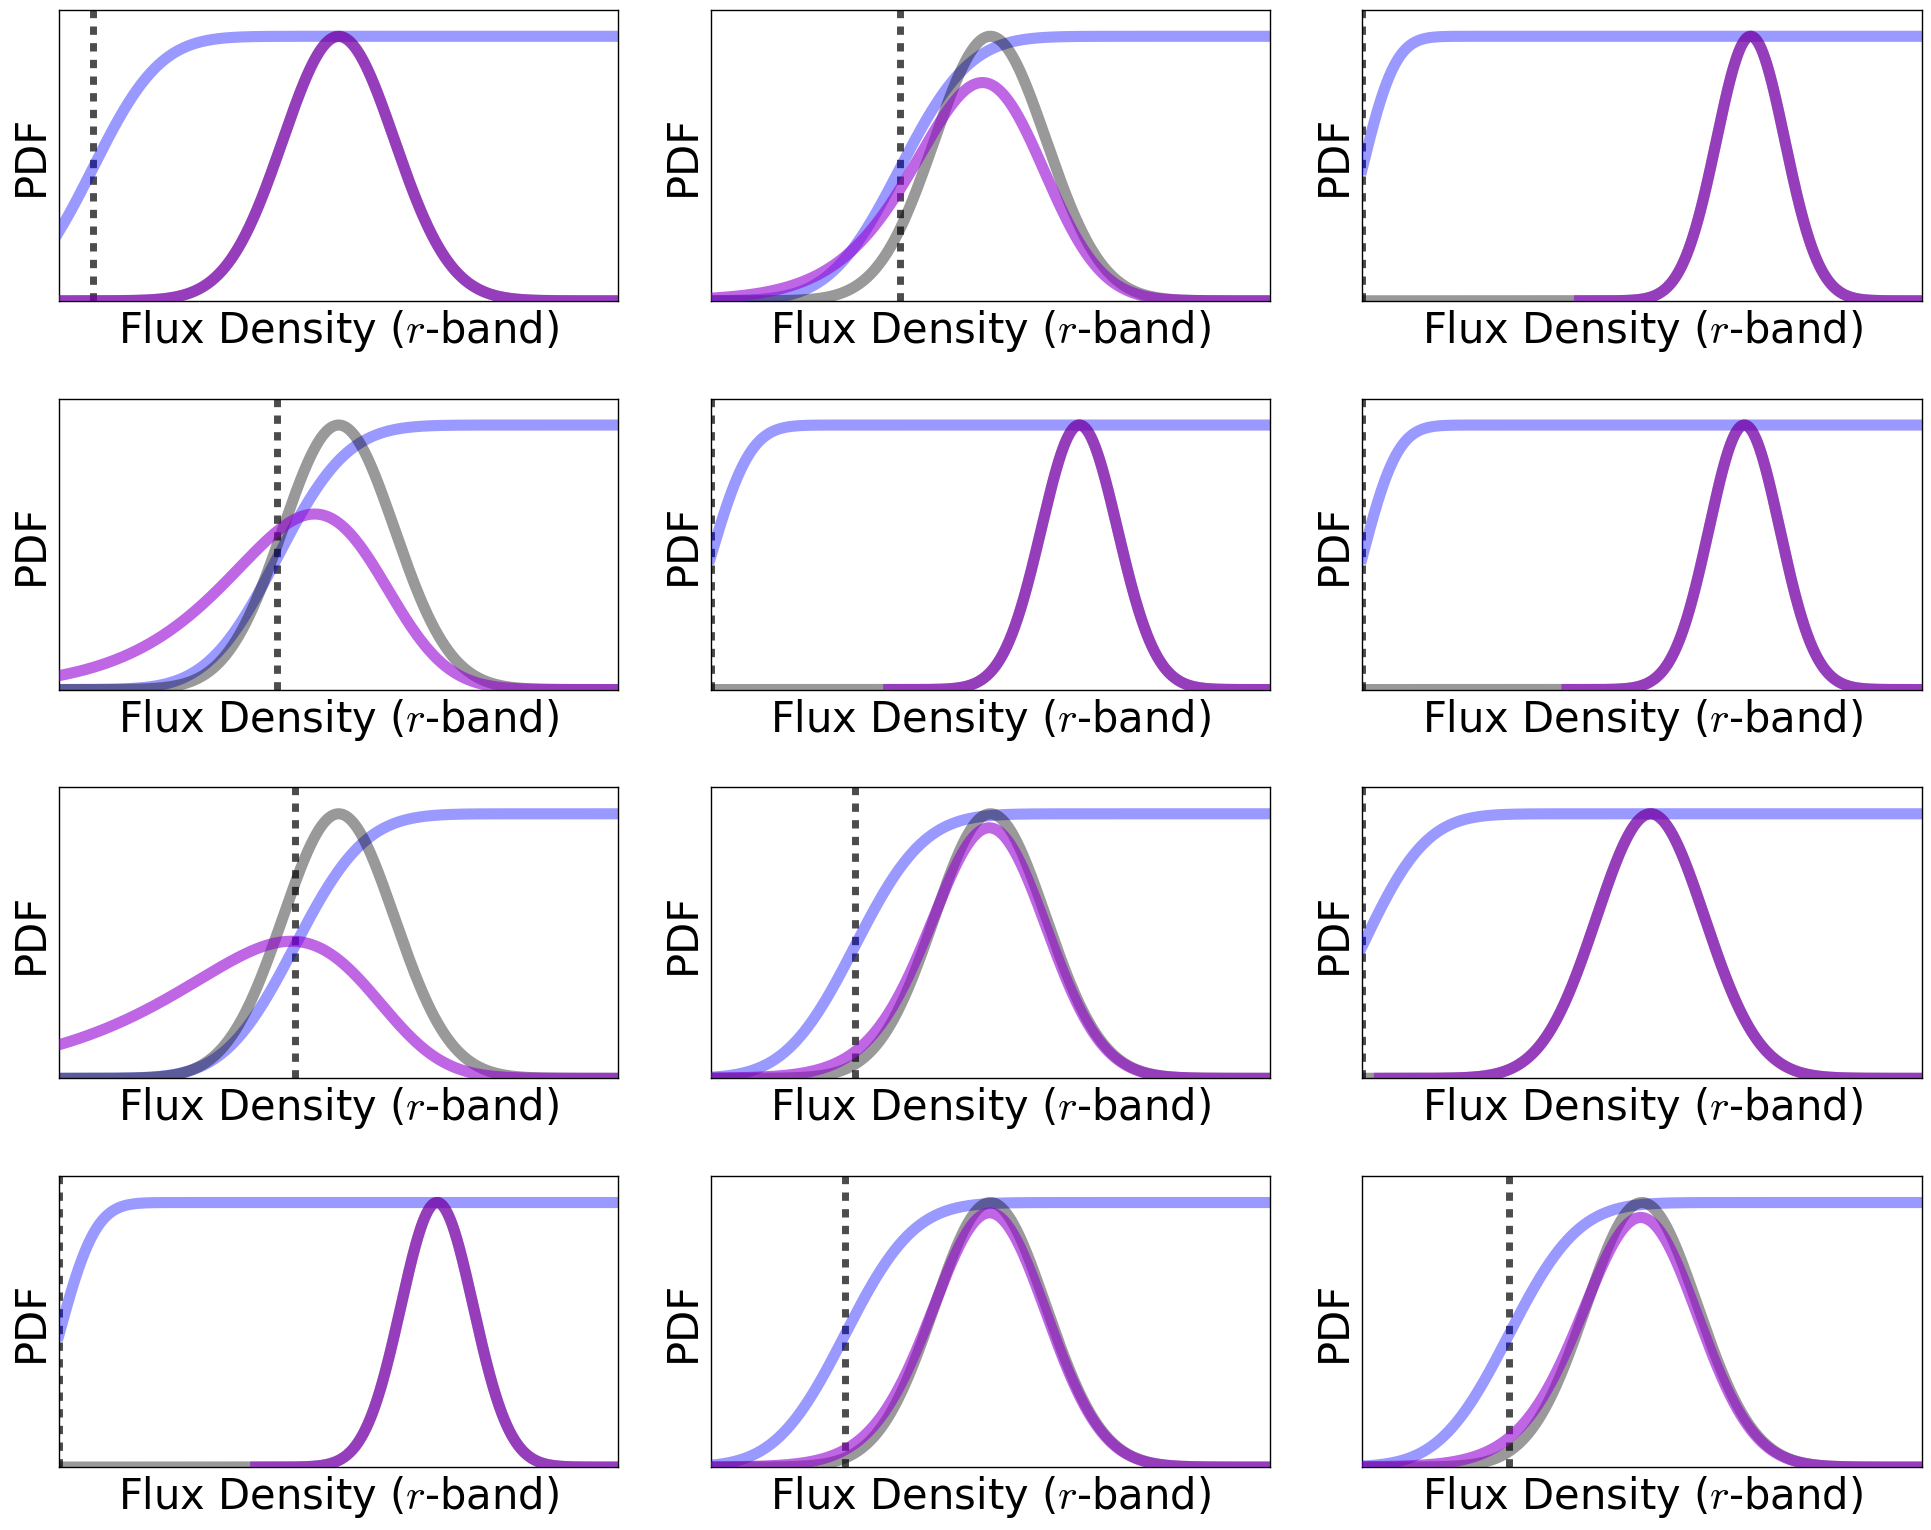

In [12]:
# plotting new results
figure(figsize=(20,16))
for i in xrange(12):
    subplot(4,3,i+1)
    mu, sdev, sdev_smooth = ftrain[i], etrain[i], etrain_smooth[i]
    fcut = 2.*sdev # cutoff threshold
    x1 = linspace(mu-50*sdev_smooth, mu+5*sdev_smooth, 10000) # flux grid
    y1 = fz.gaussian(mu, sdev_smooth, x1) # pdf
    delta = (fcut - x1) / (sqrt(2)*sdev) # relative scale (note use of original error)
    y2 = 0.5*special.erfc(delta) # selection probability
    y = y1/y2 # conditional likelihood
    y[~isfinite(y)] = 0. # remove division errors
    y /= trapz(y,x1) # normalize
    x = linspace(mu-5*sdev_smooth, mu+5*sdev_smooth, 1000) # original grid
    y = interp(x, x1, y) # interpolate onto original grid
    ymax = max(y.max(), y1.max())
    vlines(fcut, 0, ymax*1.1, colors='black', lw=5, linestyles='--', alpha=0.7, zorder=2)
    plot(x1, y1, lw=8, color='black', alpha=0.4, zorder=4)
    plot(x1, y2/y2.max()*ymax, lw=8, color='blue', alpha=0.4, zorder=3)
    plot(x, y, lw=8, color='darkviolet', alpha=0.6, zorder=5)
    xlim([min(x.min(),fcut), x.max()])
    xticks([])
    yticks([])
    ylim([0, ymax*1.1])
    xlabel('Flux Density ($r$-band)')
    ylabel('PDF')
    tight_layout()

### Conditional Posterior

We are now in a position to tackle our original likelihood. Conditioning on $s_g=1$ and $s_h=1$ given selection criteria $\mathcal{S}_g$ and $\mathcal{S}_h$, our **conditional posterior** for galaxies $g$ and $h$ is

$$
P(h|g,s_g=1,s_h=1,\mathcal{S}_g,\mathcal{S}_h) = \frac{P(g|h,s_g=1,s_h=1,\mathcal{S}_g,\mathcal{S}_h) \, P(h)}{\sum_{h \in \mathbf{h}} P(g|h,s_g=1,s_h=1,\mathcal{S}_g,\mathcal{S}_h) \, P(h)}
$$

where the conditional likelihood is 

$$ 
P(g|h,s_g=1,s_h=1,\mathcal{S}_g,\mathcal{S}_h)
= \int P(\mathbf{F}|g,s_g=1,\mathcal{S}_g) \,  P(\mathbf{F}|h,s_h=1,\mathcal{S}_h) \, d\mathbf{F} \\
= \prod_{b \in \mathbf{b}} A_{g,b}^{-1} A_{h,b}^{-1} \int \frac{\mathcal{N}(F_b|\hat{F}_{g,b},\hat{\sigma}^2_{g,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},g,b}-F_b)/(2^{1/2}\hat{\sigma}_{g,b}) \right]} \, \frac{\mathcal{N}(F_b|\hat{F}_{h,b},\hat{\sigma}^2_{h,b}+\sigma^2_{h,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},h,b}-F_b)/(2^{1/2}\hat{\sigma}_{h,b}) \right]} \, dF_b \quad .
$$ 

Unfortunately, there is no analytic solution for this integral.

### Band-Invariant Conditional Posterior

We note that in Part 3.2 we modified our original posterior such that 

$$
-2 \ln P(g|h) = ||\Delta\mathbf{\hat{F}}_{gh}||_{\mathbf{\hat{C}}_{g+h}}^{-1} - p \quad \Longrightarrow \quad P(g|h) = \left( e^{p/2} \, (2\pi)^{p/2} \, |\underline{\mathbf{\hat{C}}}_{g+h}|^{1/2} \right) \times \mathcal{N}(\Delta\mathbf{\hat{F}}_{gh}|\mathbf{0},\mathbf{\hat{C}}_{g+h}) \quad .
$$

Applying the same prefactors to our new solution, we get that

$$ 
P(g|h,s_g=1,s_h=1,\mathcal{S}_g,\mathcal{S}_h) 
= \left[2\pi e \, (\hat{\sigma}_{g,b}^2+\hat{\sigma}_{h,b}^2+\sigma^2_{h,b})\right]^{1/2} \int P(\mathbf{F}|g,s_g=1,\mathcal{S}_g) \,  P(\mathbf{F}|h,s_h=1,\mathcal{S}_h) \, d\mathbf{F} \\
\boxed{
= \prod_{b \in \mathbf{b}} \left[2\pi e \, (\hat{\sigma}_{g,b}^2+\hat{\sigma}_{h,b}^2+\sigma^2_{h,b})\right]^{1/2} A_{g,b}^{-1} A_{h,b}^{-1} \int \frac{\mathcal{N}(F_b|\hat{F}_{g,b},\hat{\sigma}^2_{g,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},g,b}-F_b)/(2^{1/2}\hat{\sigma}_{g,b}) \right]} \, \frac{\mathcal{N}(F_b|\hat{F}_{h,b},\hat{\sigma}^2_{h,b}+\sigma^2_{h,b})}{\frac{1}{2} \textrm{erfc} \left[(F_{\textrm{cut},h,b}-F_b)/(2^{1/2}\hat{\sigma}_{h,b}) \right]} \, dF_b
} \quad .
$$ 

## Application with FRANKEN-Z

Using our nearest-neighbor approximation, we only need to compute this integral over bands where the same subset of objects we've selected.

In [13]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25)

In [14]:
# fit results
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot_train, err_train_smooth, mask_train, 
                                                                 phot_test, err_test, mask_test)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 done!


Let's visualize a few examples for a particular object.

In [15]:
# select object
objid = 1
Nm = model_Nobj[objid]
m = model_obj[objid,:Nm]
ll = model_ll[objid,:Nm]
idx = argsort(ll)[:12]
ftrain, etrain, etrain_smooth = phot_train[m[idx],2], err_train[m[idx],2], err_train_smooth[m[idx],2]
ftest, etest = phot_test[objid,2], err_test[objid,2]
fcut_test = 10.*etest # cutoff (test object)
fcut_train = 2.*etrain

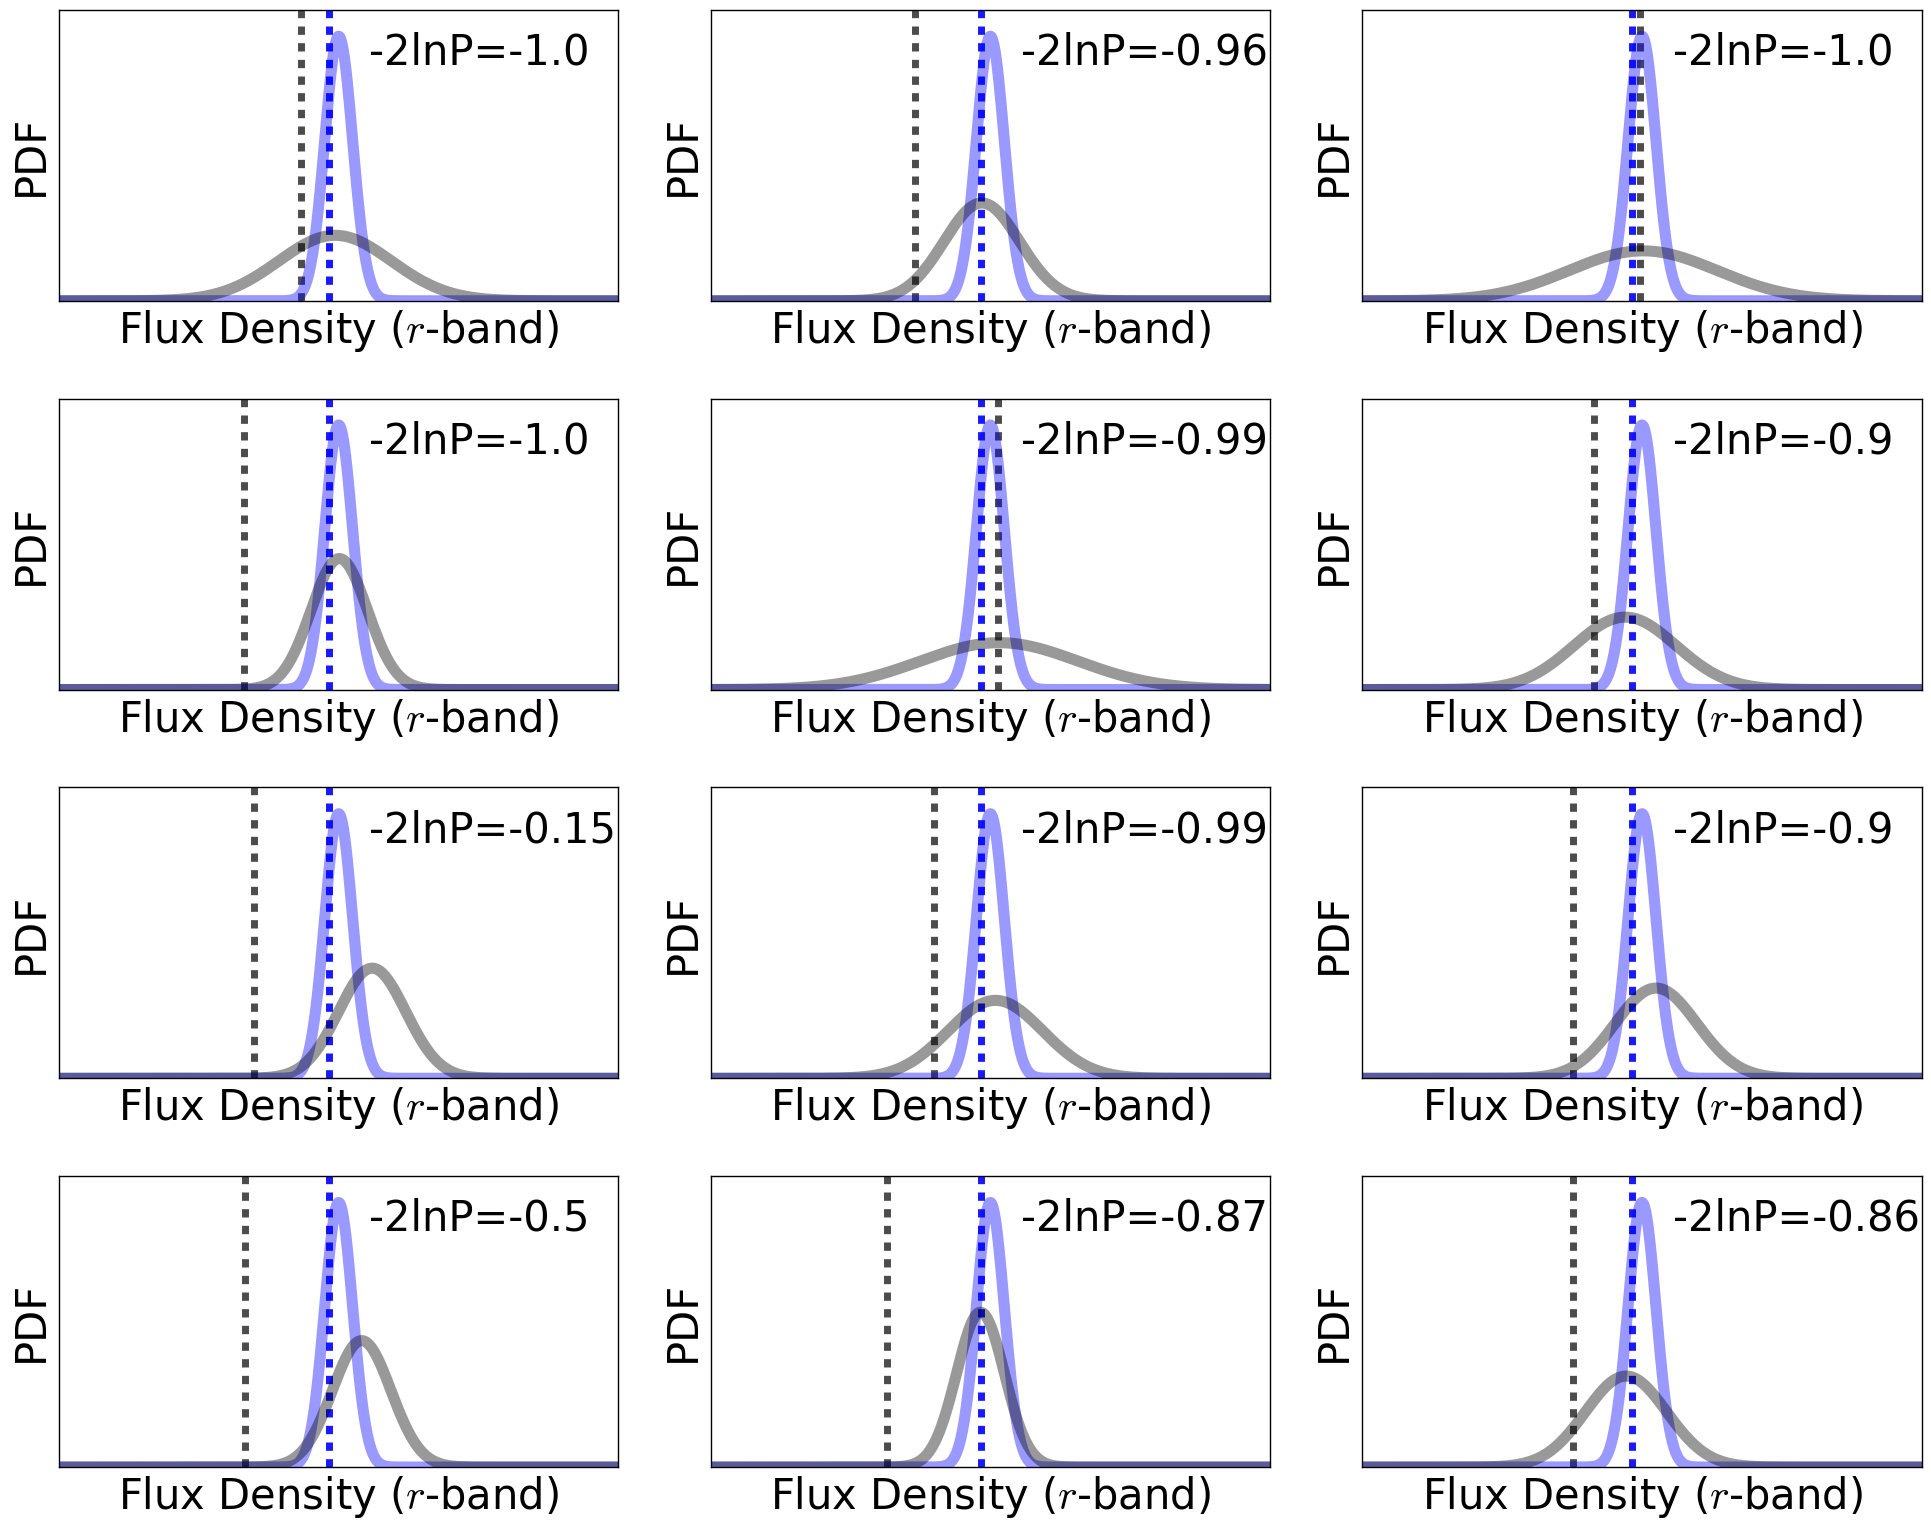

In [29]:
# plotting results ignoring selection effects
x = linspace(ftest-20*etest, ftest+20*etest, 1000)
y = fz.gaussian(ftest, etest, x)

figure(figsize=(20,16))
for i in xrange(12):
    subplot(4,3,i+1)
    mu, sdev, sdev_smooth = ftrain[i], etrain[i], etrain_smooth[i]
    y1 = fz.gaussian(mu, sdev_smooth, x)
    ymax = max(y.max(),y1.max())
    plot(x, y1, lw=8, color='black', alpha=0.4, zorder=4)
    plot(x, y, lw=8, color='blue', alpha=0.4, zorder=3)
    vlines(fcut_test, 0, ymax*1.1, colors='blue', linestyles='--', lw=5, alpha=0.9, zorder=1)
    vlines(fcut_train[i], 0, ymax*1.1, colors='black', lw=5, linestyles='--', alpha=0.7, zorder=2)
    like = trapz(y*y1,x)
    like *= sqrt(2*pi*e * (etest**2 + sdev_smooth**2))
    text(1.7, 2.7, '-2lnP='+str(round(-2*log(like),2)))
    xlim([min(x.min(),fcut), x.max()])
    xticks([])
    yticks([])
    ylim([0, ymax*1.1])
    xlabel('Flux Density ($r$-band)')
    ylabel('PDF')
    tight_layout()

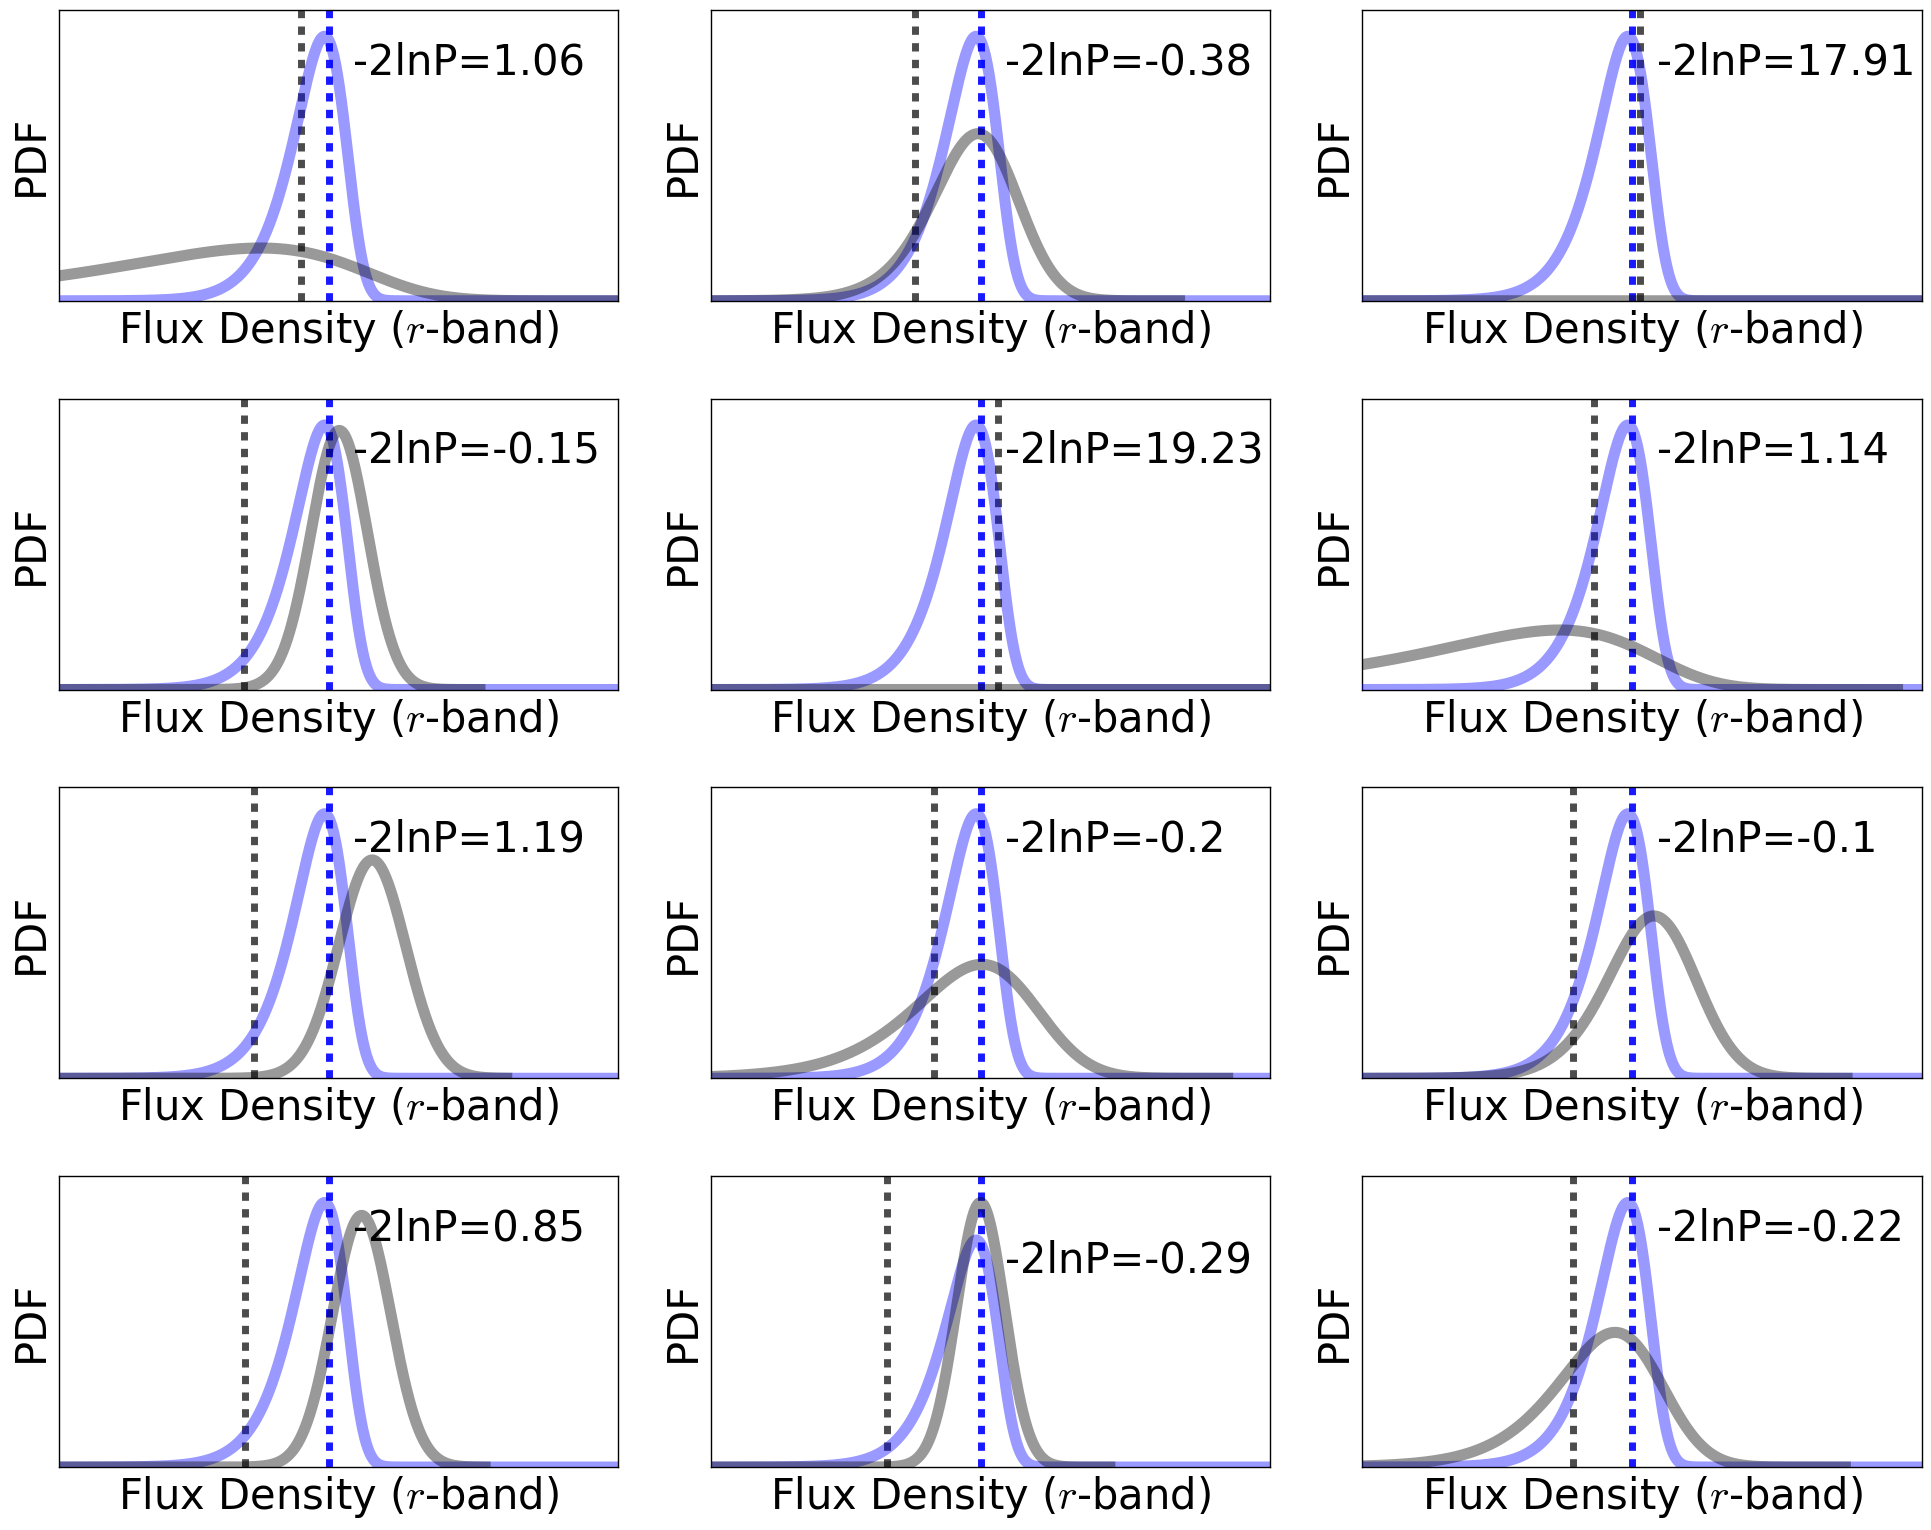

In [33]:
# plotting results including selection effects
x = linspace(ftest-20*etest, ftest+20*etest, 1000)
y = fz.gaussian(ftest, etest, x)
y /= 0.5*special.erfc((fcut_test - x)/(sqrt(2)*etest))
y /= trapz(y,x) # conditional likelihood (testing object)

figure(figsize=(20,16))
for i in xrange(12):
    subplot(4,3,i+1)
    mu, sdev, sdev_smooth = ftrain[i], etrain[i], etrain_smooth[i]
    x1 = linspace(ftest-50*sdev_smooth, ftest+5*sdev_smooth, 10000)
    y1 = fz.gaussian(mu, sdev_smooth, x1)
    y1 /= 0.5*special.erfc((fcut_train[i] - x1)/(sqrt(2)*sdev))
    y1[~isfinite(y1)] = 0.
    y1 /= trapz(y1,x1) # conditional likelihood (training object)
    y1[~isfinite(y1)] = 0.
    y1_resamp = interp(x, x1, y1)
    like = trapz(y*y1_resamp,x)
    like *= sqrt(2*pi*e * (etest**2 + sdev_smooth**2))
    ymax = max(y.max(),y1.max())
    vlines(fcut_test, 0, ymax*1.1, colors='blue', linestyles='--', lw=5, alpha=0.9, zorder=1)
    vlines(fcut_train[i], 0, ymax*1.1, colors='black', lw=5, linestyles='--', alpha=0.7, zorder=2)
    plot(x, y, lw=8, color='blue', alpha=0.4, zorder=3)
    plot(x1, y1, lw=8, color='black', alpha=0.4, zorder=4)
    text(1.55, 1.3, '-2lnP='+str(round(-2*log(like),2)))
    xlim([min(x.min(),fcut), x.max()])
    xticks([])
    yticks([])
    ylim([None, ymax*1.1])
    xlabel('Flux Density ($r$-band)')
    ylabel('PDF')
    tight_layout()

We can see that our selection effects have had a reasonable impact on our likelihoods. Let's now compute these explicitly for all of our objects.

In [43]:
model_ll2 = model_ll.copy() # new conditional likelihoods

for i in xrange(Ntest):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    ptest, etest, mtest = phot_test[i], err_test[i], mask_test[i]
    ptrain, etrain, etrain_smooth, mtrain = phot_train[midx], err_train[midx], err_train_smooth[midx], mask_train[midx]
    fcut_test = etest[2]*10. # cutoff (testing object)
    fcut_train = etrain[:,2]*2. # cutoff (training objects)
    
    # compute other bands as normal
    mtest[2] = False # pretend we have no data in band we've selected on
    model_ll2[i,:Nm] = fz.loglikelihood(ptest, etest, mtest, ptrain, etrain_smooth, mtrain)[0] # compute chi2 - N
    
    # compute conditional likelihood for target object
    x = linspace(ptest[2]-20*etest[2], ptest[2]+5*etest[2], 100) # grid
    y = fz.gaussian(ptest[2], etest[2], x) / (0.5*special.erfc((fcut_test - x)/(sqrt(2)*etest[2]))) # conditional likelihood
    y[~isfinite(y)] = 0. # check for NaNs
    y /= trapz(y,x) # normalize
    y[~isfinite(y)] = 0. # re-check for NaNs
    
    # compute conditional likelihood for training objects
    xt = array([linspace(ptrain[j,2]-20*etrain_smooth[j,2], ptrain[j,2]+5*etrain_smooth[j,2], 100) for j in xrange(Nm)])
    yt = array([fz.gaussian(ptrain[j,2], etrain_smooth[j,2], xt[j]) 
                / (0.5*special.erfc((fcut_train[j] - xt[j])/(sqrt(2)*etrain[j,2]))) 
                for j in xrange(Nm)]) # conditional likelihoods
    yt[~isfinite(yt)] = 0. # check for NaNs
    yt /= trapz(yt,xt)[:,None] # normalize
    yt[~isfinite(yt)] = 0. # re-check for NaNs
    yt_resamp = array([interp(x, xt[j], yt[j]) for j in xrange(Nm)])
    
    like = trapz(y*yt_resamp,x)
    ll = -2*log(trapz(y*yt,x)) - log(2*pi * (etest[2]**2 + etrain_smooth[:,2]**2)) - 1 # compute log-likelihoods
    model_ll2[i,:Nm] += ll # add results back into original log-likelihoods (w/ band normalization)

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 

## Results

Just as a sanity check, we can compare some of our new log-likelihoods to our original ones to see how things have changed.

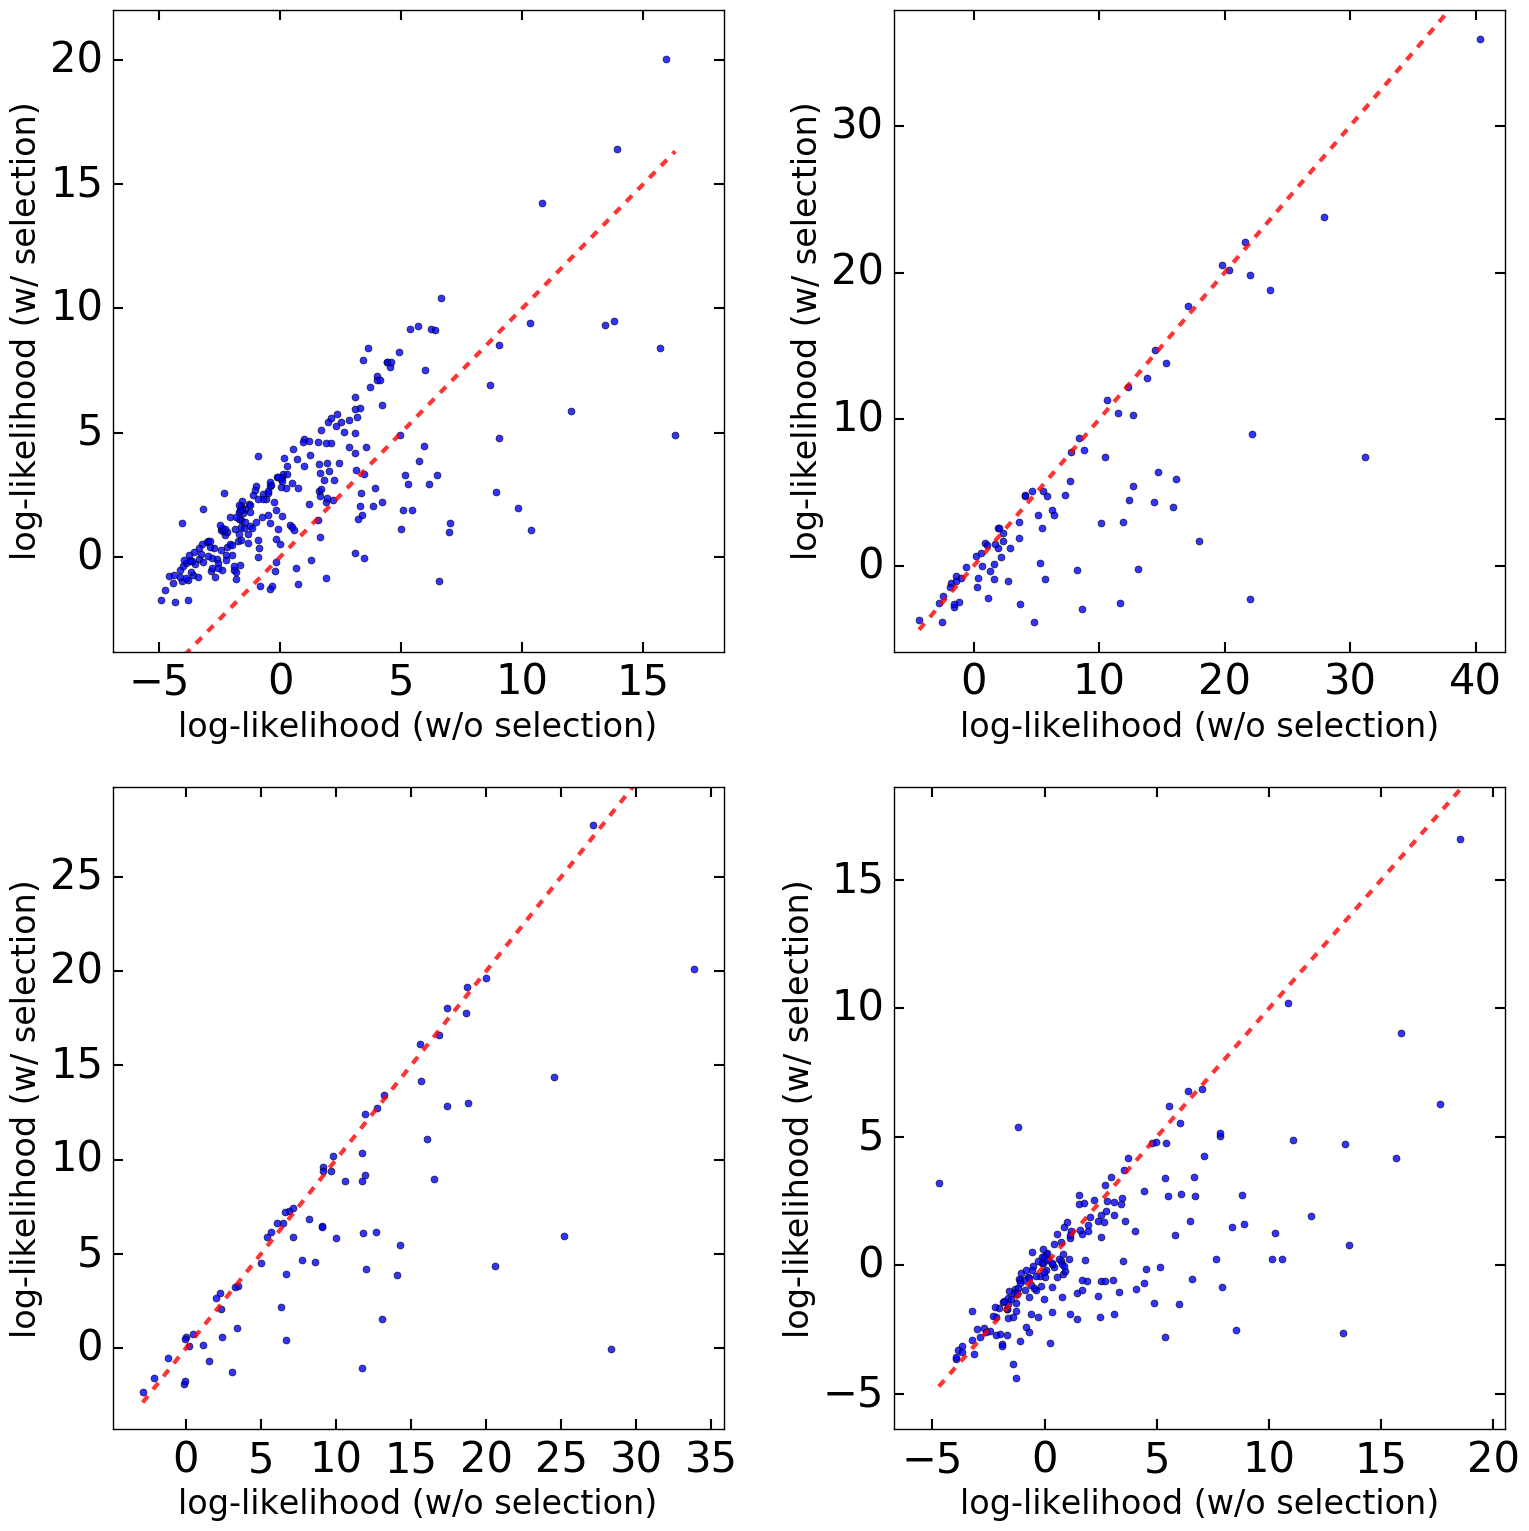

In [44]:
# plotting
figure(figsize=(16,16))
for i in xrange(4):
    subplot(2,2,i+1)
    objid = choice(Ntest) # pick a random object
    Nm = model_Nobj[objid]
    plot(model_ll[objid,:Nm], model_ll2[objid,:Nm], 'o', markersize=5, color='blue', alpha=0.8)
    plot(sort(model_ll[objid,:Nm]), sort(model_ll[objid,:Nm]), lw=3, alpha=0.8, color='red', ls='--') # one-to-one line
    xlim([model_ll[objid,:Nm].min()-2, model_ll[objid,:Nm].max()+2])
    ylim([model_ll2[objid,:Nm].min()-2, model_ll2[objid,:Nm].max()+2])
    xlabel('log-likelihood (w/o selection)', fontsize=24)
    ylabel('log-likelihood (w/ selection)', fontsize=24)
    tight_layout()

That looks reasonable. In some cases, our log-likelihoods get worse/better as the PDFs are broadened (and thus have less/more overlap). Our edge cases (far away from selection boundaries) give results that are almost identical to the our original log-likelihoods.

Let's now compare our marginalized posteriors.

In [45]:
# computing marginalized posteriors
pstack_fz, pstack_fz2 = zeros(Ntrain), zeros(Ntrain)
pmask = zeros(Ntest, dtype='bool')
for i in arange(Ntest):
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    ll, ll2 = model_ll[i,:Nm], model_ll2[i,:Nm]
    like, like2 = exp(-0.5*(ll-ll.min())), exp(-0.5*(ll2-ll2.min()))
    like /= like.sum()
    like2 /= like2.sum()
    if sum(~isfinite(like2))==0: # only stack if at least one likelihood computation went through
        pmask[i] = True
        pstack_fz[midx] += like
        pstack_fz2[midx] += like2
    
# computing redshift population distribution (w/o selection)
z_pdf_fz = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pstack_fz, 
                           rdict.grid, rdict.delta, Ntrain, rdict.Ngrid)
z_pdf_fz = z_pdf_fz[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
z_pdf_fz /= z_pdf_fz.sum()

# computing redshift population distribution (w/ selection)
z_pdf_fz2 = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], pstack_fz2, 
                            rdict.grid, rdict.delta, Ntrain, rdict.Ngrid)
z_pdf_fz2 = z_pdf_fz2[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
z_pdf_fz2 /= z_pdf_fz2.sum()

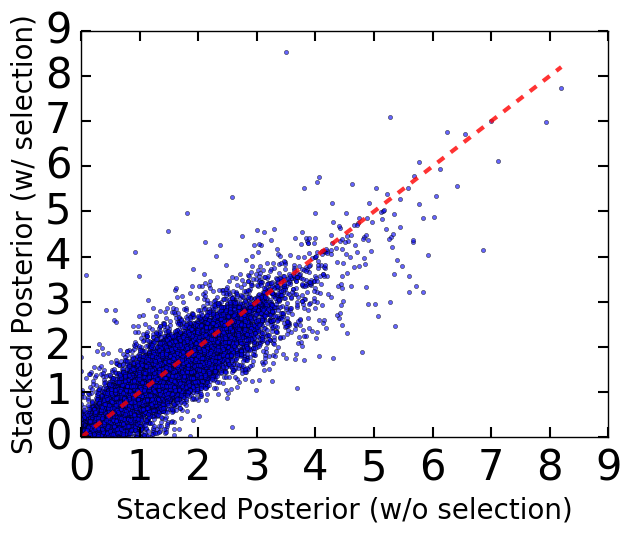

In [46]:
# comparing evidence
figure(figsize(7,6))
plot(pstack_fz, pstack_fz2, 'o', markersize=3, alpha=0.6, color='blue')
plot(sort(pstack_fz), sort(pstack_fz), lw=3, alpha=0.8, color='red', ls='--') # one-to-one line
xlabel('Stacked Posterior (w/o selection)', fontsize=20)
ylabel('Stacked Posterior (w/ selection)', fontsize=20)
tight_layout()

While there is some differences (and more scatter), on average the two results agree. Some of this scatter is likely real (induced by our selection effect), while some is likely numerical (our numerical integration scheme isn't perfect).

Finally, let's examine our relative redshift population distribution $N(z|\mathbf{g})$ generated from our modified likelihoods.

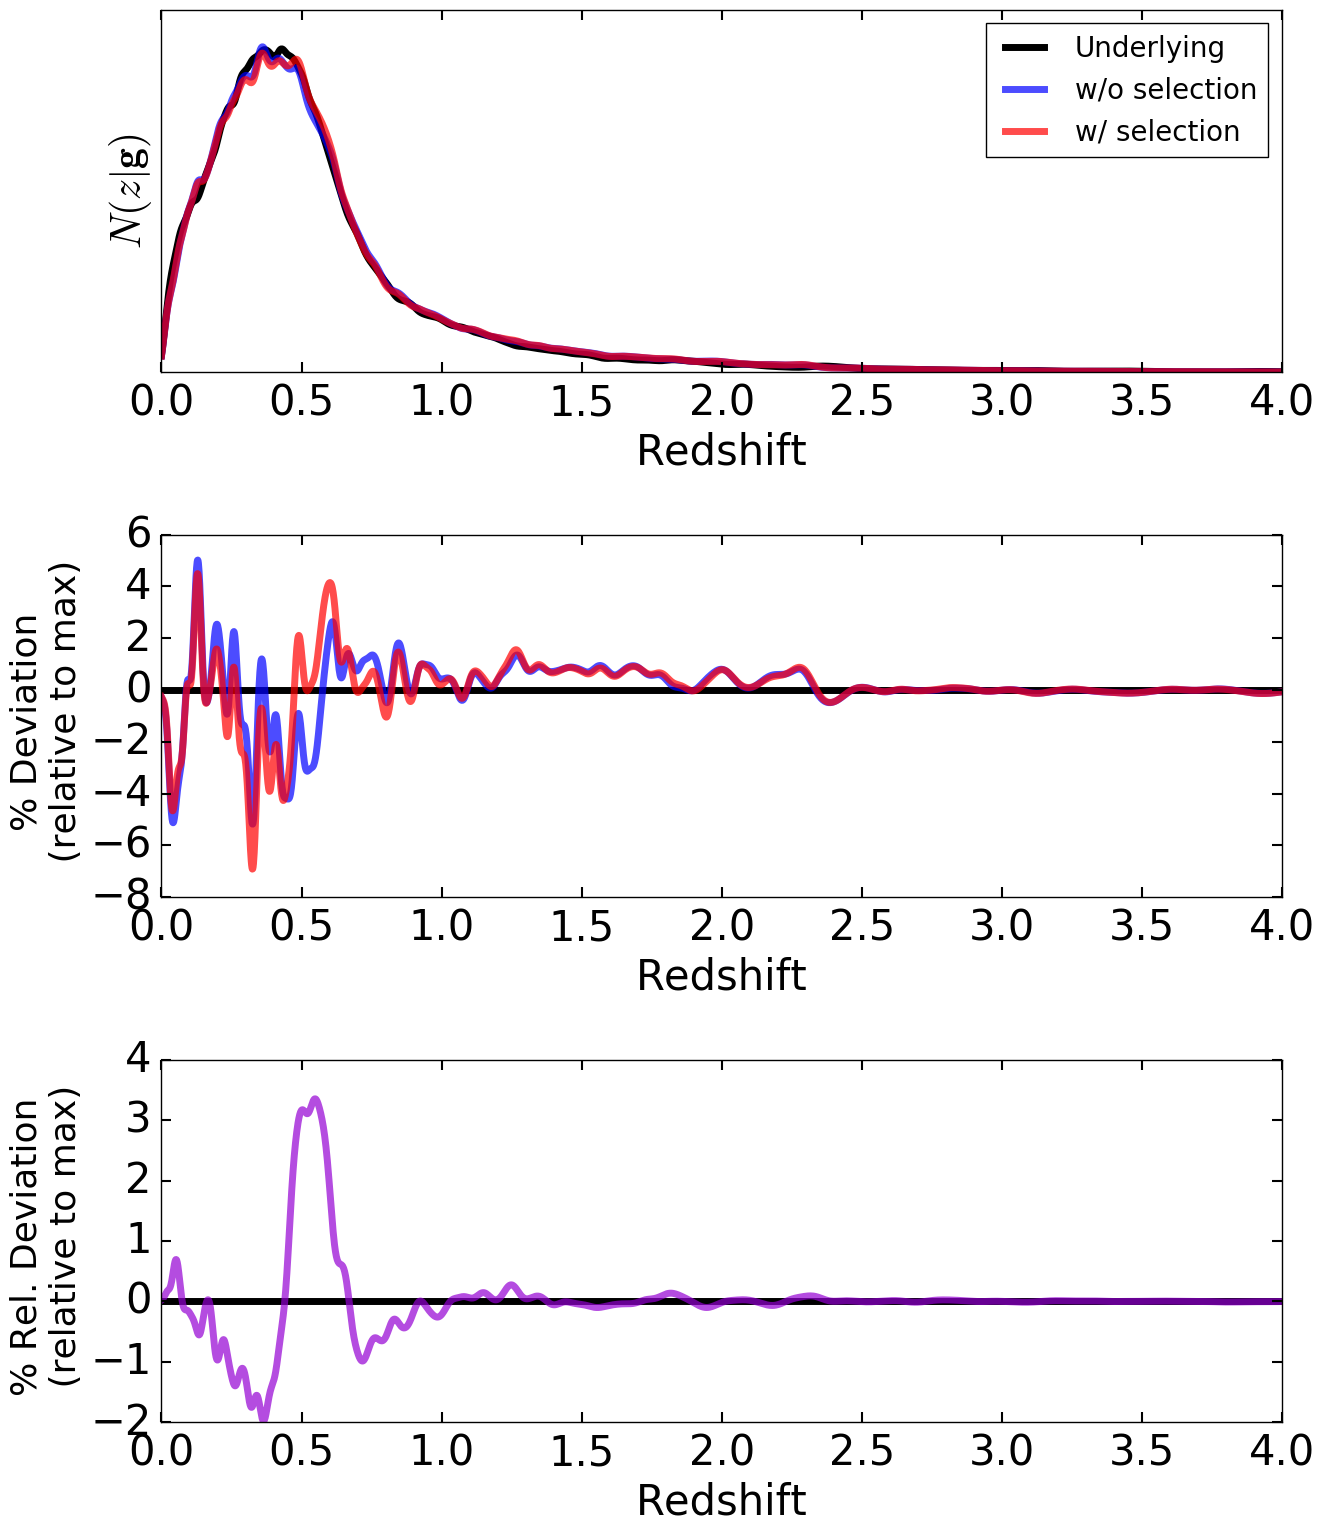

In [47]:
# truth
zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], pmask,
                       rdict.grid, rdict.delta, Ntest, rdict.Ngrid)
zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
zpdf /= zpdf.sum()

# plotting redshift distributions
figure(figsize=(14,16))
subplot(3,1,1)
plot(rdict.zgrid_highres, zpdf, lw=5, color='black', label='Underlying')
plot(rdict.zgrid_highres, z_pdf_fz, lw=5, color='blue', alpha=0.7, label='w/o selection')
plot(rdict.zgrid_highres, z_pdf_fz2, lw=5, color='red', alpha=0.7, label='w/ selection')
xlim([0,4])
yticks([])
legend(fontsize=20)
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')
tight_layout()
subplot(3,1,2)
plot([0,4], [0,0], lw=5, color='black')
plot(rdict.zgrid_highres, 100*(z_pdf_fz-z_pdf)/z_pdf.max(), color='blue', lw=5, alpha=0.7)
plot(rdict.zgrid_highres, 100*(z_pdf_fz2-z_pdf)/z_pdf.max(), color='red', lw=5, alpha=0.7)
xlim([0,4])
xlabel('Redshift')
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()
subplot(3,1,3)
plot([0,4], [0,0], lw=5, color='black')
plot(rdict.zgrid_highres, 100*(z_pdf_fz2-z_pdf_fz)/z_pdf.max(), color='darkviolet', lw=5, alpha=0.7)
xlim([0,4])
xlabel('Redshift')
ylabel('% Rel. Deviation \n (relative to max)', fontsize=26)
tight_layout()

As expected from the similar evidence weights, the two population distributions are pretty close to each other but differ in some systematic ways. Since incorporating selection effects is significantly more expensive than simply computing the Gaussian approximation, we'll explore the impact/bias of this effect (coupled with our approximations) in the following notebook (Part 4).

### Impact on Individual Objects

Our selection probability can have a significant impact on the posteriors we derive for individual objects. An example is shown below.

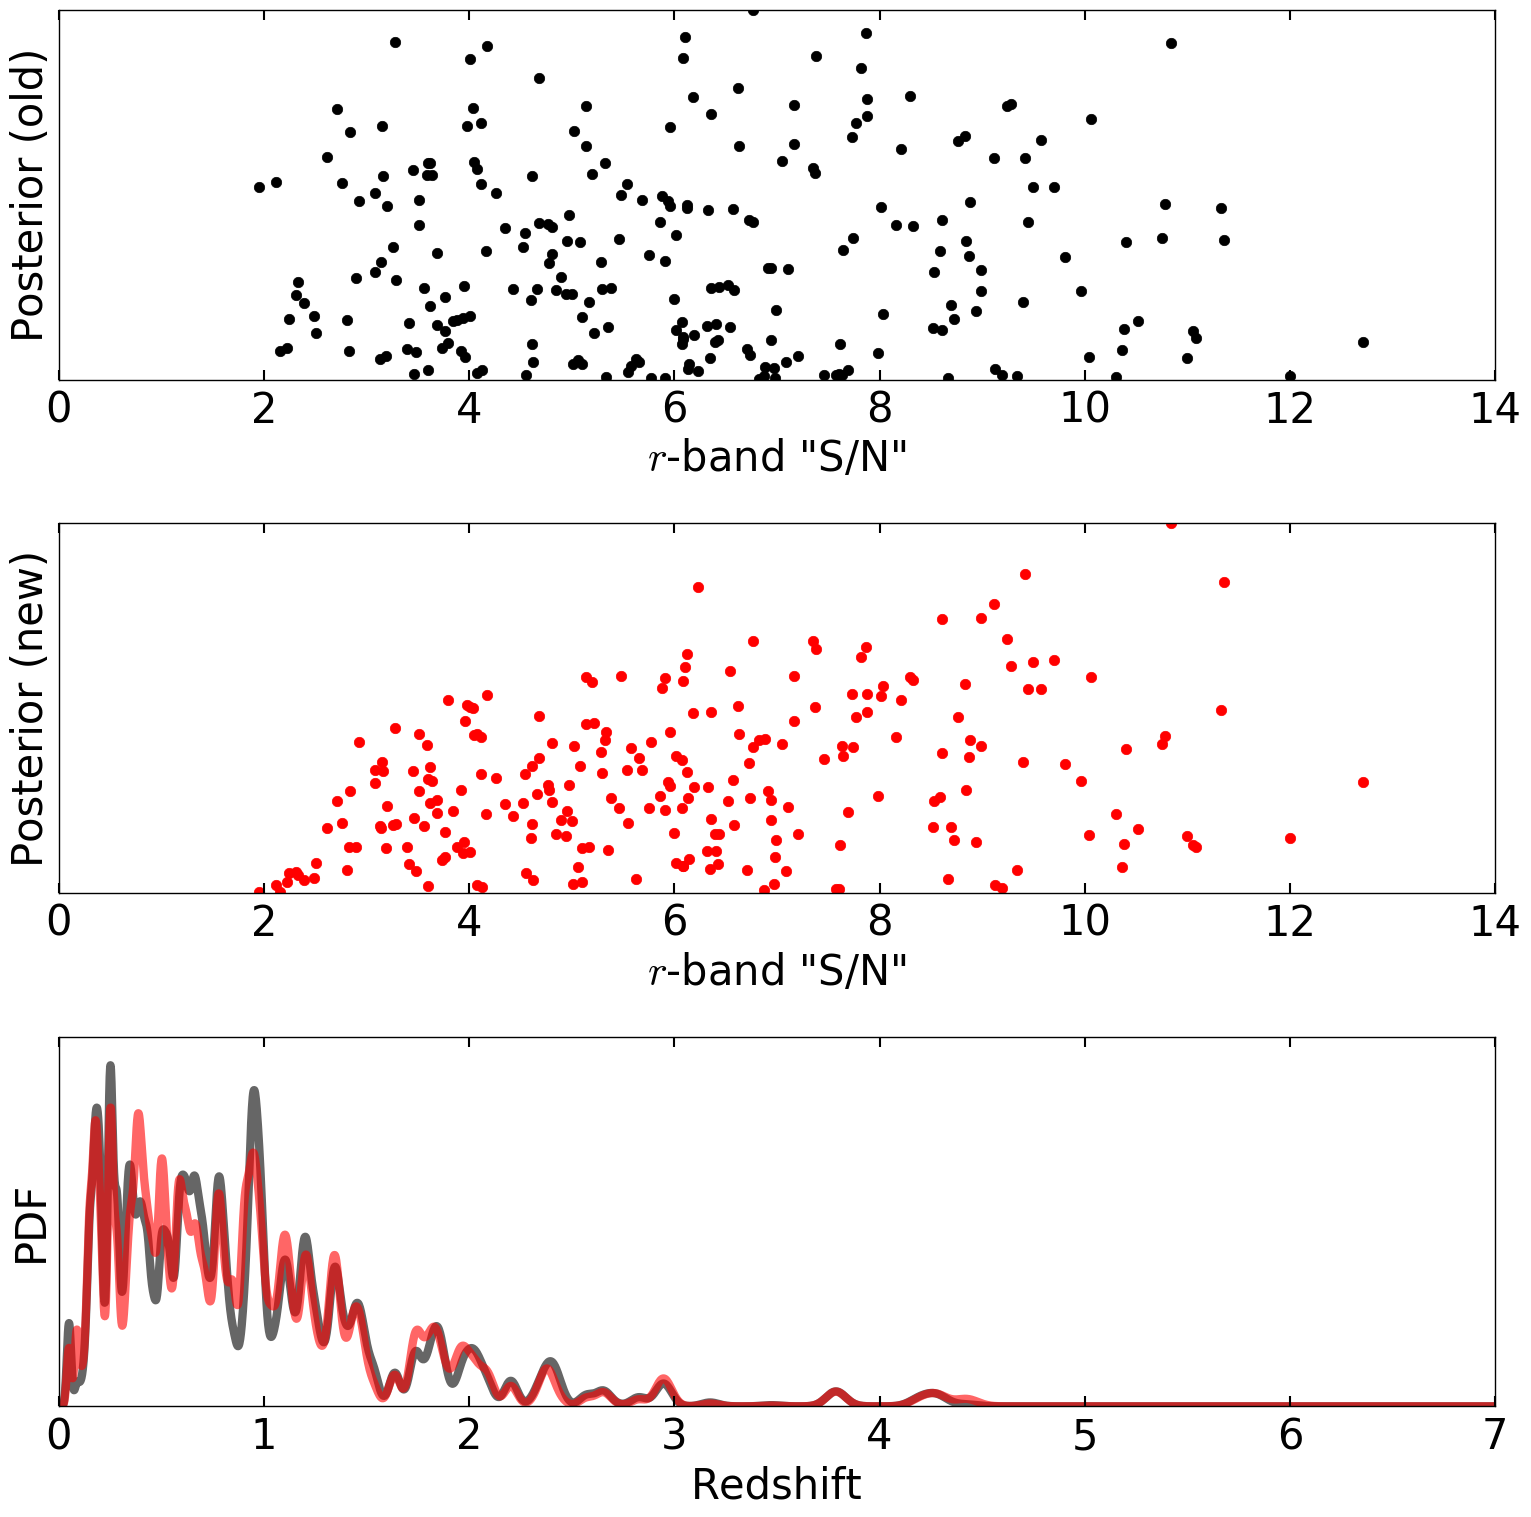

In [48]:
idx = 4 # pick object

Nm = model_Nobj[idx]
midx = model_obj[idx,:Nm]
ll, ll2 = model_ll[idx,:Nm], model_ll2[idx,:Nm]
like = exp(-0.5*(ll-ll.min()))
like2 = exp(-0.5*(ll2-ll2.min()))
ptrain, etrain = phot_train[midx], err_train[midx]
ptest, etest = phot_test[idx], err_test[idx]
sn = ptrain[:,2] / sqrt(square(etest[2]) + square(etrain[:,2])) # compute "effective S/N"

# redshift pdf (w/o selection)
pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], like, 
                      rdict.grid, rdict.delta, Nm, rdict.Ngrid)
pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
pdf /= pdf.sum() # normalizing

# redshift pdf (w/ selection)
pdf3 = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], like2, 
                       rdict.grid, rdict.delta, Nm, rdict.Ngrid)
pdf3 = pdf3[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
pdf3 /= pdf3.sum() # normalizing

figure(figsize=(16,20))
subplot(4,1,1)
plot(sn, like/like.max(), '.', markersize=15, color='black')
xlabel('$r$-band "S/N"')
ylabel('Posterior (old)')
yticks([])
tight_layout()
subplot(4,1,2)
plot(sn, like2/like2.max(), '.', markersize=15, color='red')
xlabel('$r$-band "S/N"')
ylabel('Posterior (new)')
yticks([])
tight_layout()
subplot(4,1,3)
plot(rdict.zgrid_highres, pdf, lw=6, color='black', alpha=0.6, label='Posterior (old)')
plot(rdict.zgrid_highres, pdf3, lw=6, color='red', alpha=0.6, label='Posterior (new)')
xlabel('Redshift')
ylabel('PDF')
yticks([])
tight_layout()